## Problem Statement
Let's try to examine what are the factors involved in an incomplete pass. Is it defender's closing speed that leads to a better interception of a pass and make it incomplete? If yes, what is the correlation?
 
**Intuition:** If a defender is recovering from a poor position on the field, they will most likely sprint and be out of phase instead of providing proactive coverage. By focusing on the "Ball-in-Air" window of passes, we will show that the fastest defensive sprints often signal a coverage breakdown.

To address this problem, we need the following metrics:
- **Separation distance** - How much distance is there between receiver and defender? 'Output' dataset gives us raw coordinates $(x, y)$ but not the actual velocity vectors, we have to derive the movement ourselves. First, we calculate the gap (Euclidean Separation). Then, we measure the straight-line distance between the targeted receiver $(x_t, y_t)$ and every defender $(x_d, y_d)$ on the field. $$d = \sqrt{(x_d - x_t)^2 + (y_d - y_t)^2}$$
- **Closing speed** - How fast is this gap disappearing? We look at how the separation changes from one frame to the next. Since the data captures for every 0.1 seconds, we calculate the change over time:$$v = - \frac{(d_{t} - d_{t-1})}{0.1}$$Note: We apply a negative sign here to align the math with intuition: if the gap is shrinking (a negative change in distance), it registers as a positive closing speed.
- **Out-of-phase score (or Panic Index)** - This functions as a metric to diagnose if a defender generates high closing speed after losing positional leverage (high separation). It is defined as a product of separation distance and closing speed. $$
\text{OOP Score} = \text{Separation Distance} \times \text{Closing Speed}
$$

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.patches as patches
from scipy.signal import savgol_filter as sgolay

In [2]:
base_dir = '../114239_nfl_competition_files_published_analytics_final'
train_dir = os.path.join(base_dir, 'train')

meta_df = pd.read_csv(os.path.join(base_dir, 'supplementary_data.csv'), low_memory=False)
all_weeks = []

print("Processing input and output csvs")
for week in range(1, 19):
    week_str = f"{week:02d}"
    try:
        output_path = os.path.join(train_dir, f'output_2023_w{week_str}.csv')
        week_out = pd.read_csv(output_path)
        
        input_path = os.path.join(train_dir, f'input_2023_w{week_str}.csv')
        cols = ['game_id', 'play_id', 'nfl_id', 'player_name', 'player_role', 'player_side', 'player_position']
        week_in = pd.read_csv(input_path, usecols=cols).drop_duplicates(['game_id', 'play_id', 'nfl_id'])
        
        merged = week_out.merge(week_in, on=['game_id', 'play_id', 'nfl_id'], how='left')
        all_weeks.append(merged)
        
        del week_out, week_in, merged
        gc.collect()
        
    except FileNotFoundError:
        print(f"  - Week {week_str} skipped (Expected if file doesn't exist)", end="\r") 
        continue

ball_in_air = pd.concat(all_weeks, ignore_index=True)
del all_weeks
gc.collect()

ball_in_air = ball_in_air.merge(
    meta_df[['game_id', 'play_id', 'pass_result']], 
    on=['game_id', 'play_id'], how='left'
)

print(f"All csvs merged into df. Total Frames: {len(ball_in_air):,}")

Processing input and output csvs
All csvs merged into df. Total Frames: 562,936


Calculating separation distance. Stored in `dist_smooth` column in `closest_df`

In [3]:
targets = ball_in_air[ball_in_air['player_role'] == 'Targeted Receiver'][['game_id', 'play_id', 'frame_id', 'x', 'y']]
targets = targets.rename(columns={'x': 't_x', 'y': 't_y'})
defenders = ball_in_air[ball_in_air['player_side'] == 'Defense'].copy()
analysis_df = defenders.merge(targets, on=['game_id', 'play_id', 'frame_id'], how='inner')

# Calculating Raw Distance
analysis_df['dist'] = np.sqrt((analysis_df['x'] - analysis_df['t_x'])**2 + (analysis_df['y'] - analysis_df['t_y'])**2)

# Smoothening the distance to remove any jitters between frames
def smooth_distance(series):
    if len(series) >= 5:
        return sgolay(series, window_length=5, polyorder=2)
    return series

analysis_df['dist_smooth'] = analysis_df.groupby(['game_id', 'play_id', 'nfl_id'])['dist'].transform(smooth_distance)

# Filtering to the closest defender for each receiver
analysis_df = analysis_df.sort_values(['game_id', 'play_id', 'frame_id', 'dist_smooth'])
closest_df = analysis_df.drop_duplicates(['game_id', 'play_id', 'frame_id']).copy()

Calculating closing speed by performing derivative on the separation distance data

In [4]:
closest_df = closest_df.sort_values(['game_id', 'play_id', 'frame_id'])
closest_df['dist_chg'] = closest_df['dist_smooth'].diff()
closest_df['same_play'] = closest_df['play_id'] == closest_df['play_id'].shift(1)
closest_df.loc[~closest_df['same_play'], 'dist_chg'] = np.nan
closest_df['closing_speed'] = -(closest_df['dist_chg'] / 0.1)
closest_df['oop_score'] = closest_df['dist_smooth'] * closest_df['closing_speed']

closest_df[['player_name', 'dist', 'dist_smooth', 'closing_speed', 'oop_score']].dropna().sample(5)

,player_name,dist,dist_smooth,closing_speed,oop_score
215137,Xavier McKinney,1.262696,1.262617,2.448415,3.091411
159373,Stephon Gilmore,11.964435,11.969069,-2.246699,-26.890895
385834,Logan Wilson,3.543586,3.545175,5.350346,18.967912
216259,Nick McCloud,3.630895,3.621663,7.727183,27.985252
263970,Devon Witherspoon,1.289496,1.286482,-0.508025,-0.653565


Measuring statistical significance of this hypothesis

In [5]:
if 'yards_to_go' not in closest_df.columns:
    closest_df = closest_df.merge(
        meta_df[['game_id', 'play_id', 'yards_to_go']], 
        on=['game_id', 'play_id'], 
        how='left'
    )

print("Statistical Significance Test")
group_c = closest_df[closest_df['pass_result'] == 'C']['closing_speed'].dropna()
group_i = closest_df[closest_df['pass_result'] == 'I']['closing_speed'].dropna()

t_stat, p_val = stats.ttest_ind(group_c, group_i, equal_var=False)

print(f"Complete Pass Avg Speed (Complete): {group_c.mean():.2f} yds/s")
print(f"Incomplete Pass Avg Speed: {group_i.mean():.2f} yds/s")
print(f"Difference: {group_c.mean() - group_i.mean():.2f} yds/s")
print(f"P-Value: {p_val:.2e}")

print("\nSensitivity Test (Deep Passes > 10 Yards)")
deep_c = closest_df[(closest_df['pass_result'] == 'C') & (closest_df['yards_to_go'] > 10)]['closing_speed'].mean()
deep_i = closest_df[(closest_df['pass_result'] == 'I') & (closest_df['yards_to_go'] > 10)]['closing_speed'].mean()

print(f"Deep Pass Avg Speed (C): {deep_c:.2f}")
print(f"Deep Pass Avg Speed (I): {deep_i:.2f}")
print(f"Gap: {deep_c - deep_i:.2f}")

Statistical Significance Test
Complete Pass Avg Speed (Complete): 0.90 yds/s
Incomplete Pass Avg Speed: 0.67 yds/s
Difference: 0.23 yds/s
P-Value: 5.22e-69

Sensitivity Test (Deep Passes > 10 Yards)
Deep Pass Avg Speed (C): 1.25
Deep Pass Avg Speed (I): 0.91
Gap: 0.34


When we aggregated the maximum closing speed for every play (Weeks 1–18) and compared it against the pass result, a statistically significant pattern emerged:

* **Incompletions (Defensive Wins):** Average Max Speed = **0.67 yds/sec**
* **Completions (Defensive Losses):** Average Max Speed = **0.90 yds/sec**

### Statistical Validation
This **0.23 yds/sec difference** in speed between winning and losing plays suggests a fundamental truth about coverage. A T-test confirmed this result is statistically significant with a P-value of:
$$\text{P-value} = 5.22 \times 10^{-69}$$

### Sensitivity Analysis (Deep Passes)
This value is very tiny, confirming that the divergence in defensive speed profiles is not statistical noise but a **highly consistent and robust characteristic of NFL coverage.**

To test if this paradox holds in high-leverage situations, we isolated the **Deep Pass** category (plays where yards-to-go > 10). The disparity was even more pronounced:

* **Deep Pass Completions (Losing Plays):** 1.25 yds/sec
* **Deep Pass Incompletions (Winning Plays):** 0.91 yds/sec
* **The Final Gap:** **0.34 yds/sec**

This confirms that the "Panic Index" is most profound when the stakes are highest, where the cost of being "Out-of-Phase" requires the most drastic (and ultimately unsuccessful) recovery effort.

### Does Closing Speed Prevent Catches?
To evaluate the effectiveness of defensive speed, we aggregated the Maximum Closing Speed for every play and compared it against the play's outcome.

**The Result:**
As visualized below, Completed passes (C) feature a higher average maximum closing speed than Incomplete passes (I). This supports our hypothesis that high defensive velocity is a "lagging indicator": a symptom of a defender sprinting to recover from a lost position.

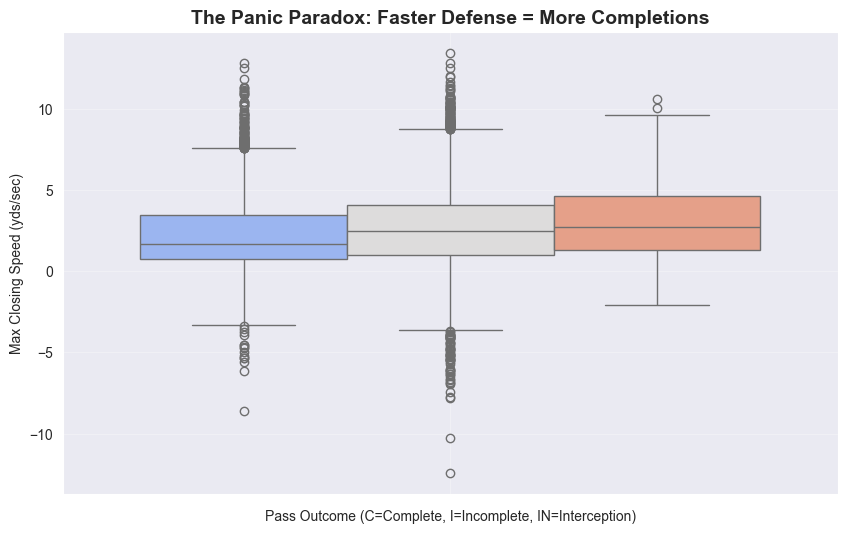

Average Max Closing Speed by Outcome:
pass_result
C     2.628208
I     2.265648
IN    3.162629
Name: closing_speed, dtype: float64


In [6]:
# Identify Max Speed per play
idx = closest_df.groupby(['game_id', 'play_id'])['closing_speed'].idxmax()
play_max_speed = closest_df.loc[idx].copy()

if 'pass_result' not in play_max_speed.columns:
    play_max_speed = play_max_speed.merge(
        ball_in_air[['game_id', 'play_id', 'pass_result']].drop_duplicates(), 
        on=['game_id', 'play_id']
    )

plt.figure(figsize=(10, 6))
sns.boxplot(data=play_max_speed, hue='pass_result', y='closing_speed', palette='coolwarm', legend=False)

plt.title("The Panic Paradox: Faster Defense = More Completions", fontsize=14, fontweight='bold')
plt.ylabel("Max Closing Speed (yds/sec)")
plt.xlabel("Pass Outcome (C=Complete, I=Incomplete, IN=Interception)")
plt.grid(True, alpha=0.3)

plt.savefig('panic_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Average Max Closing Speed by Outcome:")
print(play_max_speed.groupby('pass_result')['closing_speed'].mean())

Top 10 'Panicked' Defenders Leaderboard
 nfl_id         player_name position  oop_score
  52475       Julian Okwara      OLB  40.717062
  55999            Jay Ward       SS  34.328004
  42368       Shaq Thompson      MLB  31.124344
  54686 Tariq Castro-Fields       CB  27.980906
  52410         Chase Young      OLB  24.197449
  55043         Jake Hansen      OLB  24.071610
  47939      Justin Hollins      OLB  21.565549
  44865          Teez Tabor       FS  20.724589
  55047    Tristin McCollum       SS  18.728115
  56111           D.J. Ivey       CB  18.346510


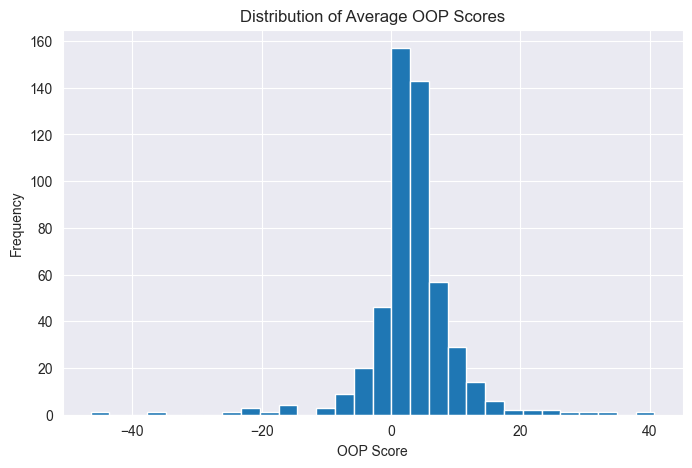

In [7]:
if 'closest_df' not in globals() or closest_df.empty:
    raise RuntimeError("closest_df not found. Please run metric calculation cell.")

# Define coverage positions (standard NFL abbreviations)
COVERAGE_POSITIONS = {'CB', 'S', 'FS', 'SS', 'LB', 'MLB', 'OLB'}

# Filter to defenders in coverage roles
coverage_df = closest_df[
    (closest_df['player_side'] == 'Defense') &
    (closest_df['player_position'].isin(COVERAGE_POSITIONS)) &
    (closest_df['oop_score'].notna())
]

# Aggregate mean OOP score per player
leaderboard = (
    coverage_df
    .groupby(['nfl_id', 'player_name', 'player_position'])['oop_score']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

leaderboard = leaderboard.rename(columns={'player_position': 'position'})

# Display top 10 panicked players
print("Top 10 'Panicked' Defenders Leaderboard")
print(leaderboard.head(10).to_string(index=False))

plt.figure(figsize=(8, 5))
plt.hist(leaderboard['oop_score'], bins=30)
plt.xlabel('OOP Score')
plt.ylabel('Frequency')
plt.title('Distribution of Average OOP Scores')
plt.show()

### Performance based on OOP Score

The O.O.P. Score penalizes bursts of speed that occur only after a defender has already lost leverage. Rather than rewarding raw athleticism, the metric emphasizes positional efficiency shifting evaluation from volume of speed to quality of positioning.

Based on empirical analysis across the full season, we propose the following performance tiers:

| Tier | O.O.P. Score | Interpretation |
|------|--------------|----------------|
| **In-Phase** | < 15 | Controlled, proactive coverage. The defender maintains tight positioning, rendering high-speed recovery unnecessary. Reflects high technical efficiency. |
| **Recovery Mode** | 15 – 40 | The defender has lost initial leverage and is now accelerating to re-establish proximity. Competitive but reactive—common on well-executed offensive routes. |
| **Panic State** | > 40 | The defender is sprinting at high velocity (>10 yds/s) while still >4 yards from the receiver. Indicates a complete breakdown in coverage; speed is maximal but futile. |

Intuitively, this score quantifies the defender's panic. A panicked player will most likely be further from a favorable position (high separation distance) and will run faster to close that gap (high closing speed). Hence, this also signifies **Panic Index**.

![alt text](panic_concept_diagram_v2_clean.png "Title")

### Visualizing the "Ball-in-Air" Window

To validate that our metrics reflect real on-field dynamics,and not data artifacts. We animated the play with the **highest recorded closing speed** in our dataset (Weeks 1–9). This play exemplifies the **“Panic State”**: a defender sprinting at maximum effort while significantly out of phase with the targeted receiver.

The animation (saved as `panic_play_enhanced.gif`) includes:
- **All offensive and defensive players**, colored red and blue respectively,
- The **targeted receiver** highlighted with a gold star,
- The **closest defender** (as identified by our O.O.P. pipeline) marked in cyan,
- A **dashed white line** connecting the two to visualize separation distance in real time,
- A live display of **separation distance, closing speed, and O.O.P. Score** for each frame,
- A clear label marking the **frame of peak closing speed**,
- Final play outcome (**Completion** or **Incompletion**) shown in the last few frames.

This visualization confirms that extreme closing speed in our top-ranked play occurs during a genuine recovery sprint validating both the **kinematic derivation** and the **diagnostic power** of the O.O.P. Score. 

In [15]:
def create_football_field(linenumbers=True, endzones=True, figsize=(12, 6.33)):
    fig, ax = plt.subplots(1, figsize=figsize)
    rect = patches.Rectangle((0, 0), 120, 53.3, facecolor='darkgreen', zorder=0)
    ax.add_patch(rect)
    ax.plot([0, 0, 120, 120, 0], [0, 53.3, 53.3, 0, 0], color='white', linewidth=2)
    for x in range(10, 120, 10):
        ax.plot([x, x], [0, 53.3], color='white', alpha=0.5, linewidth=1)
    for x in range(10, 120):
        if x % 10 == 0:
            continue
        ax.plot([x, x], [53.3 - 1, 53.3], color='white', alpha=0.5)
        ax.plot([x, x], [0, 1], color='white', alpha=0.5)
        ax.plot([x, x], [23, 24], color='white', alpha=0.5)
        ax.plot([x, x], [29.3, 30.3], color='white', alpha=0.5)
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x if x <= 50 else 120 - x
            ax.text(x, 5, str(numb), ha='center', fontsize=20, color='white')
            ax.text(x, 53.3 - 5, str(numb), ha='center', fontsize=20, color='white', rotation=180)
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3, facecolor='blue', alpha=0.2, zorder=0)
        ez2 = patches.Rectangle((110, 0), 10, 53.3, facecolor='blue', alpha=0.2, zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    ax.set_xlim(0, 120)
    ax.set_ylim(-5, 58.3)
    ax.axis('off')
    return fig, ax

top_play_row = closest_df.sort_values('closing_speed', ascending=False).iloc[0]
test_game_id = int(top_play_row['game_id'])
test_play_id = int(top_play_row['play_id'])
max_speed_frame = int(top_play_row['frame_id'])

outcome = meta_df[
    (meta_df['game_id'] == test_game_id) & 
    (meta_df['play_id'] == test_play_id)
]['pass_result'].iloc[0]

print(f"Animating 'Top Panic' Play: Game {test_game_id}, Play {test_play_id}")
print(f"Outcome: {'Completion' if outcome == 'C' else 'Incompletion'}")
print(f"Max Closing Speed at Frame: {max_speed_frame}")

play_tracking = ball_in_air[
    (ball_in_air['game_id'] == test_game_id) & 
    (ball_in_air['play_id'] == test_play_id)
].copy()

# Get frames (Ball-in-Air window only)
frames_to_use = sorted(play_tracking['frame_id'].unique())
last_frame = frames_to_use[-1]

target_info = play_tracking[play_tracking['player_role'] == 'Targeted Receiver'][['frame_id', 'x', 'y']].set_index('frame_id')

oop_play = closest_df[
    (closest_df['game_id'] == test_game_id) &
    (closest_df['play_id'] == test_play_id)
][['frame_id', 'dist_smooth', 'closing_speed', 'oop_score', 'player_name']].set_index('frame_id')

def animate_play_enhanced(df, target_info, oop_play, frames, max_speed_frame, outcome, last_frame):
    fig, ax = create_football_field()
    
    off_scatter = ax.scatter([], [], c='red', s=100, label='Offense', zorder=5, edgecolors='white')
    def_scatter = ax.scatter([], [], c='blue', s=100, label='Defense', zorder=5, edgecolors='white')
    target_scatter = ax.scatter([], [], c='gold', s=200, marker='*', label='Targeted Receiver', zorder=6, edgecolors='black')
    closest_scatter = ax.scatter([], [], c='cyan', s=180, edgecolors='black', linewidth=2, zorder=7)
    
    sep_line, = ax.plot([], [], color='white', linestyle='--', linewidth=2, alpha=0.7, zorder=4)
    
    info_txt = ax.text(10, 50, '', fontsize=11, color='white', fontweight='bold',
                       bbox=dict(facecolor='black', alpha=0.6))
    max_speed_txt = ax.text(60, 50, '', fontsize=13, color='orange', fontweight='bold',
                            bbox=dict(facecolor='black', alpha=0.7), visible=False)
    outcome_txt = ax.text(60, 45, '', fontsize=12, color='lime' if outcome == 'C' else 'white',
                          fontweight='bold', bbox=dict(facecolor='black', alpha=0.7), visible=False)
    
    ax.legend(loc='upper right')
    
    def update(frame):
        current = df[df['frame_id'] == frame]
        off_data = current[current['player_side'] == 'Offense']
        def_data = current[current['player_side'] == 'Defense']
        
        off_scatter.set_offsets(off_data[['x', 'y']].values if not off_data.empty else np.empty((0, 2)))
        def_scatter.set_offsets(def_data[['x', 'y']].values if not def_data.empty else np.empty((0, 2)))
        
        if frame in target_info.index:
            rx, ry = target_info.loc[frame, ['x', 'y']]
            target_scatter.set_offsets([[rx, ry]])
        else:
            target_scatter.set_offsets(np.empty((0, 2)))
        
        if frame in oop_play.index:
            row = oop_play.loc[frame]
            dist = row['dist_smooth']
            speed = row['closing_speed']
            oop = row['oop_score']
            d_name = row['player_name']
            
            def_pos = current[(current['player_side'] == 'Defense') & (current['player_name'] == d_name)]
            if not def_pos.empty:
                dx, dy = def_pos.iloc[0]['x'], def_pos.iloc[0]['y']
                closest_scatter.set_offsets([[dx, dy]])
                if frame in target_info.index:
                    rx, ry = target_info.loc[frame, ['x', 'y']]
                    sep_line.set_data([dx, rx], [dy, ry])
                else:
                    sep_line.set_data([], [])
            else:
                closest_scatter.set_offsets(np.empty((0, 2)))
                sep_line.set_data([], [])
            
            info_txt.set_text(
                f"Frame: {frame}\n"
                f"Separation: {dist:.1f} yds\n"
                f"Closing Speed: {speed:.1f} yds/s\n"
                f"OOP Score: {oop:.1f}"
            )
        else:
            closest_scatter.set_offsets(np.empty((0, 2)))
            sep_line.set_data([], [])
            info_txt.set_text(f"Frame: {frame}\n— No OOP data —")
        
        # Highlight max speed frame
        if frame == max_speed_frame:
            max_speed_txt.set_text("MAX CLOSING SPEED")
            max_speed_txt.set_visible(True)
        else:
            max_speed_txt.set_visible(False)
        
        # Show outcome in last 3 frames
        if frame >= last_frame - 2:
            outcome_txt.set_text("COMPLETION" if outcome == 'C' else "INCOMPLETION")
            outcome_txt.set_visible(True)
        else:
            outcome_txt.set_visible(False)
        
        return off_scatter, def_scatter, target_scatter, closest_scatter, sep_line, info_txt, max_speed_txt, outcome_txt

    anim = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=False, repeat=False)
    plt.close()
    return anim

anim = animate_play_enhanced(
    play_tracking,
    target_info,
    oop_play,
    frames_to_use,
    max_speed_frame,
    outcome,
    last_frame
)

anim.save('panic_play_enhanced.gif', writer='pillow', fps=10)
print("Animation saved for panic play")

# Display in notebook
HTML(anim.to_jshtml())

Animating 'Top Panic' Play: Game 2023100107, Play 4000
Outcome: Completion
Max Closing Speed at Frame: 2
Animation saved for panic play


### Conclusion

The Out-of-Phase Score (or Panic Index) presents evaluation method for defensive plays: the fastest moments often reveal the deepest flaws. By quantifying when speed is a symptom of being “Out of Phase,” it shifts focus from raw athleticism to **positional intelligence** a critical but often overlooked dimension of coverage quality.

Future work should prioritize using the O.O.P. Score for predictive frameworks for real-time coaching and broadcast applications.